In [2]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


questions :
pas d'entrainement du discriminateur, grave ou pas ?
cv des scénarios vers une même valeur ?

In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import precision_score, recall_score, f1_score,\
                            #accuracy_score, balanced_accuracy_score,classification_report,\
                            #plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split

import lightgbm as lgb
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle

np.random.seed(1635848)

In [5]:
import tensorflow as tf
tf.config.run_functions_eagerly(False)
tensor = tf.constant([1, 2, 3])
numpy_array = tensor.numpy()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler

class InterestRatePIGAN:
    def __init__(self, latent_dim=32, time_steps=40, rate_columns=None):
        self.latent_dim = latent_dim
        self.time_steps = time_steps
        self.rate_columns = rate_columns
        self.n_rates = len(rate_columns) if rate_columns else 0

        if self.n_rates == 0:
            raise ValueError("Vous devez spécifier rate_columns avec les colonnes contenant les taux")

        self.input_dim = latent_dim + 1 + self.n_rates

        # Paramètres CIR à apprendre
        self.kappa = tf.Variable(tf.random.uniform([self.n_rates], 0.01, 0.1), trainable=True, name="kappa")
        self.theta = tf.Variable(tf.random.uniform([self.n_rates], 0.01, 0.1), trainable=True, name="theta")
        self.sigma = tf.Variable(tf.random.uniform([self.n_rates], 0.3, 0.8), trainable=True, name="sigma")

        self.optimizer = tf.keras.optimizers.legacy.Adam(0.001)

        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=self.optimizer,
                                   metrics=['accuracy'])

        self.build_combined_model()

    def build_generator(self):
        model = tf.keras.Sequential([
            layers.Dense(128, activation='tanh', input_dim=self.input_dim),
            layers.Dense(256, activation='tanh'),
            layers.Dense(128, activation='tanh'),
            layers.Dense(self.n_rates)
        ])
        return model

    def build_discriminator(self):
        model = tf.keras.Sequential([
            layers.Dense(128, activation='tanh', input_dim=self.n_rates + 1),
            layers.Dense(256, activation='tanh'),
            layers.Dense(128, activation='tanh'),
            layers.Dense(1, activation='sigmoid')
        ])
        return model

    def build_combined_model(self):
        self.discriminator.trainable = False
        z = layers.Input(shape=(self.latent_dim,))
        t = layers.Input(shape=(1,))
        r0 = layers.Input(shape=(self.n_rates,))

        input_concat = layers.concatenate([z, t, r0])
        rates = self.generator(input_concat)
        validity = self.discriminator(layers.concatenate([t, rates]))
        self.combined = models.Model([z, t, r0], [validity, rates])
        self.combined.compile(loss=['binary_crossentropy', 'mse'],
                              optimizer=self.optimizer)

    def physics_loss(self, z, t, r0, r_true):
        t_tensor = tf.convert_to_tensor(t, dtype=tf.float32)
        z_tensor = tf.convert_to_tensor(z, dtype=tf.float32)
        r0_tensor = tf.convert_to_tensor(r0, dtype=tf.float32)

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(t_tensor)
            inputs = tf.concat([z_tensor, t_tensor, r0_tensor], axis=1)
            r_pred = self.generator(inputs)

        dr_dt = tape.batch_jacobian(r_pred, t_tensor)
        dr_dt = tf.squeeze(dr_dt, axis=-1)

        # Paramètres CIR : kappa, theta, sigma
        kappa = tf.expand_dims(self.kappa, axis=0)
        theta = tf.expand_dims(self.theta, axis=0)
        sigma = tf.expand_dims(tf.nn.softplus(self.sigma), axis=0)


        noise = tf.random.normal(tf.shape(r_pred), dtype=tf.float32)
        sqrt_r = tf.sqrt(tf.math.maximum(r_pred, 1e-6))

        drift = kappa * (theta - r_pred)
        diffusion = sigma * sqrt_r * noise
        residual = dr_dt - (drift + diffusion)


        # Régularisation légère
        #reg = 0.001 * (
        #    tf.reduce_mean(tf.square(kappa - 0.05)) +
        #    tf.reduce_mean(tf.square(theta - 0.03)))
        #    tf.reduce_mean(tf.square(sigma - 0.02))
        

        return tf.reduce_mean(tf.square(residual))

    def train_step(self, z, real_t, real_rates, r0_batch, batch_size):
        valid = tf.ones((batch_size, 1))
        fake = tf.zeros((batch_size, 1))

        z_tensor = tf.convert_to_tensor(z, dtype=tf.float32)
        t_tensor = tf.convert_to_tensor(real_t, dtype=tf.float32)
        r0_tensor = tf.convert_to_tensor(r0_batch, dtype=tf.float32)

        with tf.GradientTape() as tape_adv:
            inputs = tf.concat([z_tensor, t_tensor, r0_tensor], axis=1)
            gen_rates = self.generator(inputs, training=True)
            validity = self.discriminator(tf.concat([t_tensor, gen_rates], axis=1), training=False)
            adv_loss = tf.keras.losses.binary_crossentropy(valid, validity)

        adv_gradients = tape_adv.gradient(adv_loss, self.generator.trainable_variables)

        with tf.GradientTape() as tape_phys:
            tape_phys.watch([self.kappa, self.theta, self.sigma])
            p_loss = self.physics_loss(z, real_t, r0_batch, real_rates)

        phys_gradients = tape_phys.gradient(
            p_loss,
            self.generator.trainable_variables + [self.kappa, self.theta, self.sigma]
        )

        combined_gradients = []
        for adv_grad, phys_grad in zip(adv_gradients + [None, None, None], phys_gradients):
            if adv_grad is not None and phys_grad is not None:
                combined_gradients.append(adv_grad + 0.5 * phys_grad)
            elif phys_grad is not None:
                combined_gradients.append(phys_grad)
            else:
                combined_gradients.append(None)

        all_vars = self.generator.trainable_variables + [self.kappa, self.theta, self.sigma]
        valid_grads = [(g, v) for g, v in zip(combined_gradients, all_vars) if g is not None]

        if valid_grads:
            self.optimizer.apply_gradients(valid_grads)
        else:
            print("Les gradients ne sont pas valides, l'entraînement ne peut pas continuer.")

        return adv_loss.numpy().mean(), p_loss.numpy()

    def train(self, data, epochs, batch_size=32, plot_losses=False):
        scenarios = data.groupby('Scenario')
        all_rates = []
        all_times = []

        for _, scenario in scenarios:
            times = scenario['Time_Step'].values
            rates = scenario[self.rate_columns].values
            all_rates.append(rates)
            all_times.append(times)

        all_rates = np.array(all_rates)
        all_times = np.array(all_times)
        r0 = all_rates[:, 0, :]
        adv_losses = []
        phys_losses = []

        for epoch in range(epochs):
            scenario_idx = np.random.randint(0, len(all_times), batch_size)
            time_idx = np.random.randint(0, self.time_steps, batch_size)

            real_t = all_times[scenario_idx, time_idx].reshape(-1, 1)
            real_rates = all_rates[scenario_idx, time_idx]
            r0_batch = r0[scenario_idx]

            z = np.random.normal(-1, 1, (batch_size, self.latent_dim))
            adv_loss, p_loss = self.train_step(z, real_t, real_rates, r0_batch, batch_size)
            adv_losses.append(adv_loss)
            phys_losses.append(p_loss)


            if epoch % 50 == 0:
                print(f"Epoch {epoch} | Adv Loss: {adv_loss:.4f} | Phys Loss: {p_loss:.4f}")
                #print(f"  kappa: {self.kappa.numpy()}")
                #print(f"  theta: {self.theta.numpy()}")
                #print(f"  sigma: {self.sigma.numpy()}")
            
        if plot_losses:
            import matplotlib.pyplot as plt
            plt.plot(adv_losses, label='Adversarial Loss')
            plt.plot(phys_losses, label='Physical Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.title('Loss Curves during Training')
            plt.grid(True)
            plt.show()

    def generate_scenarios(self, data, n_scenarios=10):
        rate_columns = [col for col in data.columns if 'EUR_Nom_Spot' in col]
        rate_data = data[rate_columns]
        scaler = StandardScaler()
        scaled_rates = scaler.fit_transform(rate_data)
        data[rate_columns] = scaled_rates

        r0 = data[rate_columns].iloc[0].values
        scenarios = np.zeros((n_scenarios, self.time_steps, self.n_rates))

        for scen_idx in range(n_scenarios):
            rt = tf.constant(r0.reshape(1, self.n_rates), dtype=tf.float32)
            scenarios[scen_idx, 0] = r0

            for t in range(1, self.time_steps):
                z_t = tf.random.normal((1, self.latent_dim))
                t_input = tf.constant([[t]], dtype=tf.float32)

                input_tensor = tf.concat([z_t, t_input, rt], axis=1)
                rates = self.generator(input_tensor, training=False)

                # 💡 Injection explicite de bruit à chaque step
                #noise = tf.random.normal((1, self.n_rates))
                #sigma = tf.nn.softplus(self.sigma)  # ensure positivity
                #rates = rates + sigma * noise  # marche aléatoire (additive)

                scenarios[scen_idx, t] = rates.numpy()
                rt = rates  # feedback pour le step suivant

        return scenarios



In [ ]:
#chargement scénario déterministe
scenario_deterministe = pd.read_csv("EUR_4Q24_CertaintyEquivalentScenarios.csv",sep=";", encoding="utf-8")
scenario_deterministe = scenario_deterministe.replace(',', '.', regex=True).astype(float)
scenario_deterministe.columns = scenario_deterministe.columns.str.replace(' ', '_')

In [ ]:
#chargement 10 scénario GSE
data=pd.read_csv("EUR_4Q24_EUR.csv",sep=";", encoding="utf-8")
data = data.replace(',', '.', regex=True).astype(float)
data.columns = data.columns.str.replace(' ', '_')

Epoch 0 | Adv Loss: 1.1801 | Phys Loss: 0.1944
Epoch 50 | Adv Loss: 0.0583 | Phys Loss: 0.8888
Epoch 100 | Adv Loss: 0.0275 | Phys Loss: 0.7309
Epoch 150 | Adv Loss: 0.0214 | Phys Loss: 0.7649
Epoch 200 | Adv Loss: 0.0197 | Phys Loss: 0.7696
Epoch 250 | Adv Loss: 0.0157 | Phys Loss: 0.5155


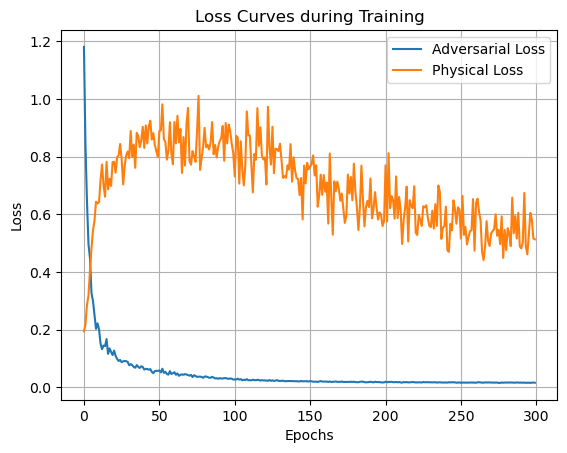

In [137]:
# Initialisation et entraînement
rate = [col for col in data.columns if 'EUR_Nom_Spot_' in col]
pigan = InterestRatePIGAN(latent_dim=164, time_steps=41,rate_columns=rate)

pigan.train(data, epochs=300, batch_size=32, plot_losses=True)

In [ ]:
#Je cherche les meilleurs hyperparamètres
def test_latent_dim(data, latent_dims, epochs=300, batch_size=32):
    for latent_dim in latent_dims:
        print(f"\nTesting with latent_dim={latent_dim}...")
        pigan = InterestRatePIGAN(latent_dim=latent_dim, time_steps=41, rate_columns=rate)

        # Entraînement complet
        pigan.train(data, epochs=epochs, batch_size=batch_size, plot_losses=False)

# Tester pour différentes valeurs de latent_dim
latent_dims = [32, 64, 128, 164]  # Exemples de dimensions latentes
test_latent_dim(data, latent_dims, epochs=300, batch_size=32)


Testing with latent_dim=32...
Epoch 0 | Adv Loss: 0.2316 | Phys Loss: 0.2339
Epoch 50 | Adv Loss: 0.0205 | Phys Loss: 0.2997
Epoch 100 | Adv Loss: 0.0166 | Phys Loss: 0.3441
Epoch 150 | Adv Loss: 0.0160 | Phys Loss: 0.3334
Epoch 200 | Adv Loss: 0.0145 | Phys Loss: 0.2731
Epoch 250 | Adv Loss: 0.0138 | Phys Loss: 0.2529
Latent Dim 32 -> Final Adv Loss: 0.0134 | Final Phys Loss: 0.2891

Testing with latent_dim=64...
Epoch 0 | Adv Loss: 1.2313 | Phys Loss: 0.1720
Epoch 50 | Adv Loss: 0.0854 | Phys Loss: 1.6717
Epoch 100 | Adv Loss: 0.0533 | Phys Loss: 1.5564
Epoch 150 | Adv Loss: 0.0438 | Phys Loss: 1.3234
Epoch 200 | Adv Loss: 0.0331 | Phys Loss: 1.1152


KeyboardInterrupt: 

In [103]:
# Génération de scénarios
new_scenarios = pigan.generate_scenarios(data,n_scenarios=100)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


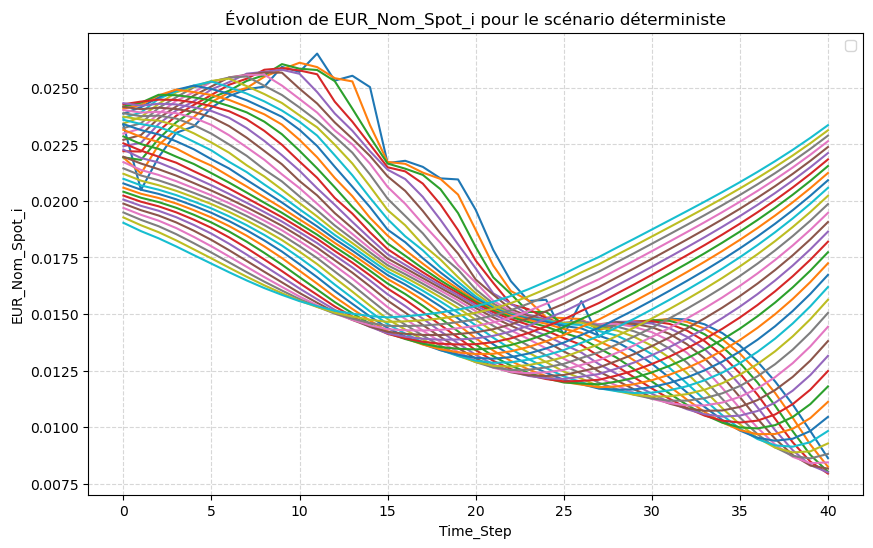

In [ ]:
#allure du scénario déterministe complet
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))

X = scenario_deterministe.iloc[:, 1]  # Time_Step (colonne 2)
for i in range(40):
    Y = scenario_deterministe.iloc[:, i+2]  # EUR_Nom_Spot_3 (colonne 5)
    plt.plot(X,Y)
    
plt.title('Évolution de EUR_Nom_Spot_i pour le scénario déterministe')
plt.xlabel('Time_Step')
plt.ylabel('EUR_Nom_Spot_i')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


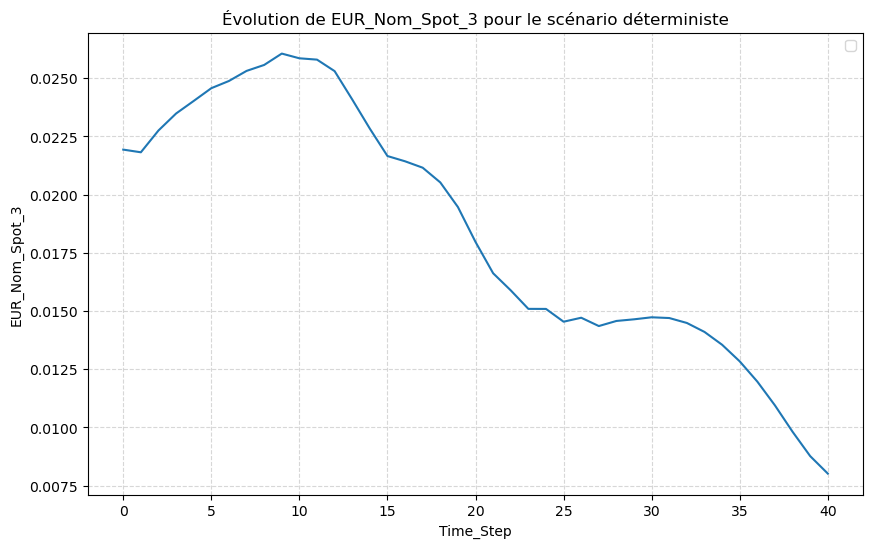

In [68]:
#si on regarde juste EUR_Nom_Spot_3 du scénario 
plt.figure(figsize=(10, 6))

X = scenario_deterministe.iloc[:, 1]  # Time_Step (colonne 2)
Y = scenario_deterministe.iloc[:, 4]  # Time_Step (colonne 5)
plt.plot(X,Y)
plt.title('Évolution de EUR_Nom_Spot_3 pour le scénario déterministe')
plt.xlabel('Time_Step')
plt.ylabel('EUR_Nom_Spot_3')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


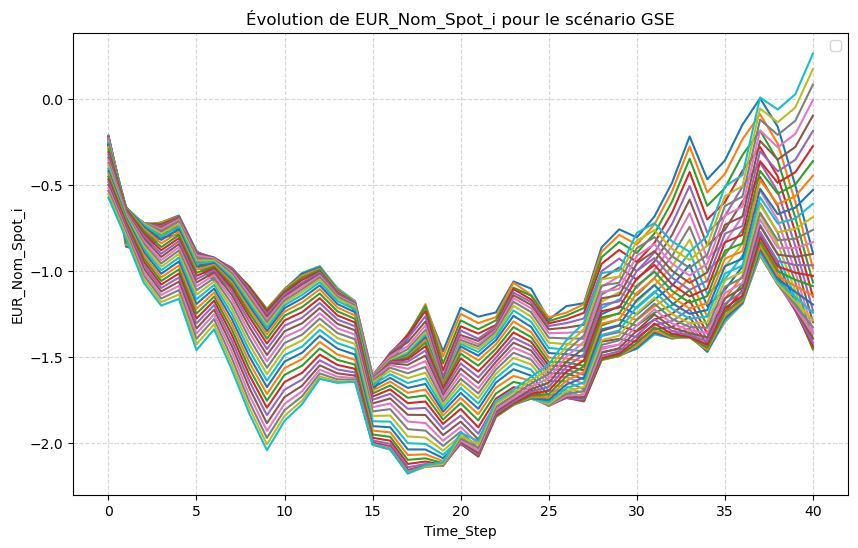

In [69]:
#pour le scénario 1 du GSE
plt.figure(figsize=(10, 6))

scenario_data=data.iloc[0:41]
X = scenario_data.iloc[:, 1]  # Time_Step (colonne 2)
for i in range(40):
    Y = scenario_data.iloc[:, i+2]  # EUR_Nom_Spot_3 (colonne 5)
    plt.plot(X,Y)
    
plt.title('Évolution de EUR_Nom_Spot_i pour le scénario GSE')
plt.xlabel('Time_Step')
plt.ylabel('EUR_Nom_Spot_i')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


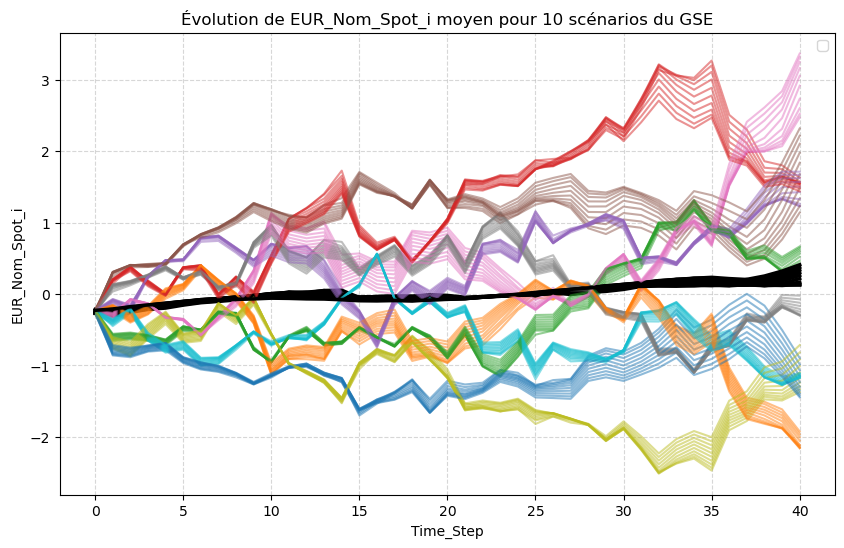

In [ ]:
#allure en perspective du GSE
import matplotlib.pyplot as plt
import pandas as pd  # Assure-toi que pandas est importé

plt.figure(figsize=(10, 6))
for i in range(10):

    all_Y = []  # Pour stocker les valeurs Y de chaque scénario
    common_X = None  # X est commun à tous les scénarios (Time_Step)

    # On suppose que les scénarios sont numérotés de 1 à 10 et couvrent 41 time steps chacun
    for scenario_num in range(1, 11):
        start_idx = (scenario_num - 1) * 41
        end_idx = start_idx + 41
        
        scenario_data = data.iloc[start_idx:end_idx]
        X = scenario_data.iloc[:, 1]  # Time_Step (colonne 2)
        Y = scenario_data.iloc[:, i+2]  # EUR_Nom_Spot_3 (colonne 5)


        all_Y.append(Y.values)  # On stocke les Y sous forme de tableau numpy
        plt.plot(X, Y, alpha=0.5)  # Tracer chaque courbe de scénario

    # Calcul de la moyenne pour chaque time step
    import numpy as np
    mean_Y = np.mean(all_Y, axis=0)  # Moyenne sur les 10 scénarios

    # Ajouter la courbe de moyenne
    plt.plot(common_X, mean_Y, color='black', linewidth=2.5)

plt.title('Évolution de EUR_Nom_Spot_i moyen pour 10 scénarios du GSE')
plt.xlabel('Time_Step')
plt.ylabel('EUR_Nom_Spot_i')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


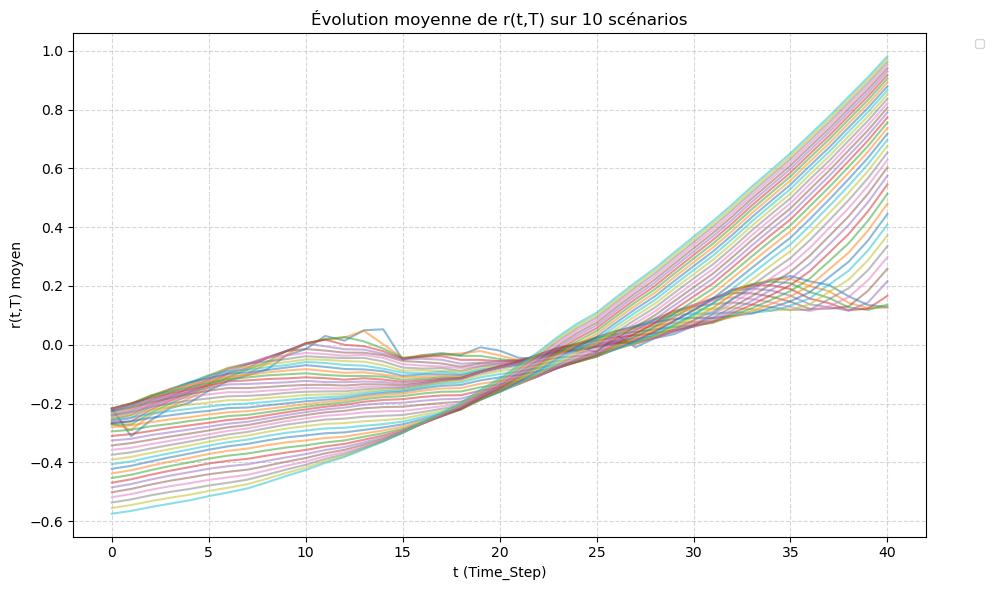

In [86]:
#allure moyenne du GSE avec 10 scénarios
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(10, 6))

n_scenarios = 10
time_steps = 41
n_maturities = 40  # T de 0 à 40
start_col = 2  # EUR_Nom_Spot_1 commence à l'indice 2

# Initialiser un tableau 3D (scenario, t, T)
all_data = np.zeros((n_scenarios, time_steps, n_maturities))

for scenario_num in range(n_scenarios):
    start_idx = scenario_num * time_steps
    end_idx = start_idx + time_steps

    scenario_data = data.iloc[start_idx:end_idx]
    rates = scenario_data.iloc[:, start_col:start_col + n_maturities].values
    all_data[scenario_num] = rates

# Moyenne sur les scénarios
mean_data = np.mean(all_data, axis=0)  # shape (t, T)

# Tracer la courbe moyenne pour chaque T
for T in range(n_maturities):
    plt.plot(range(time_steps), mean_data[:, T], alpha=0.5)

plt.title('Évolution moyenne de r(t,T) sur 10 scénarios')
plt.xlabel('t (Time_Step)')
plt.ylabel('r(t,T) moyen')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()


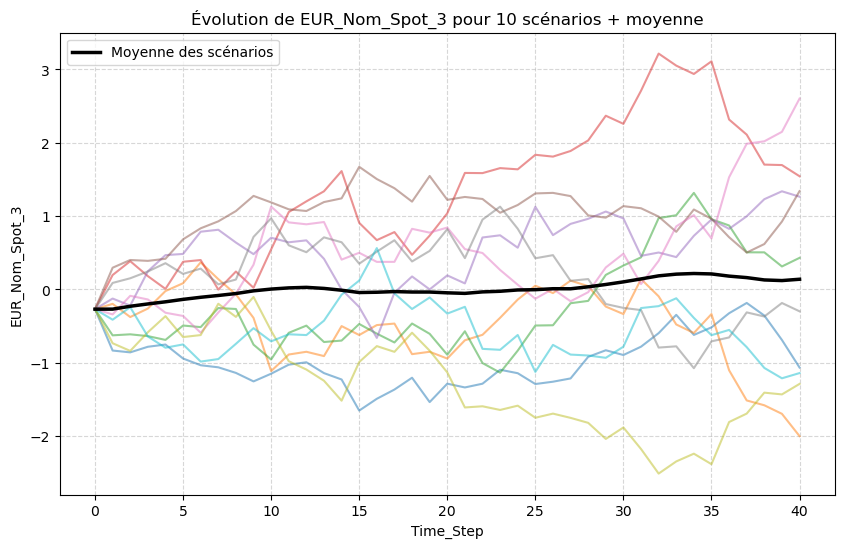

In [81]:
#si on regarde juste EUR_Nom_Spot_3 moyen du GSE
import matplotlib.pyplot as plt
import pandas as pd  # Assure-toi que pandas est importé

plt.figure(figsize=(10, 6))

all_Y = []  # Pour stocker les valeurs Y de chaque scénario
common_X = None  # X est commun à tous les scénarios (Time_Step)

# On suppose que les scénarios sont numérotés de 1 à 10 et couvrent 41 time steps chacun
for scenario_num in range(1, 11):
    start_idx = (scenario_num - 1) * 41
    end_idx = start_idx + 41
    
    scenario_data = data.iloc[start_idx:end_idx]
    X = scenario_data.iloc[:, 1]  # Time_Step (colonne 2)
    Y = scenario_data.iloc[:, 4]  # EUR_Nom_Spot_3 (colonne 5)

    if common_X is None:
        common_X = X  # On garde X pour la moyenne

    all_Y.append(Y.values)  # On stocke les Y sous forme de tableau numpy
    plt.plot(X, Y, alpha=0.5)  # Tracer chaque courbe de scénario

# Calcul de la moyenne pour chaque time step
import numpy as np
mean_Y = np.mean(all_Y, axis=0)  # Moyenne sur les 10 scénarios

# Ajouter la courbe de moyenne
plt.plot(common_X, mean_Y, color='black', linewidth=2.5, label='Moyenne des scénarios')

plt.title('Évolution de EUR_Nom_Spot_3 pour 10 scénarios + moyenne')
plt.xlabel('Time_Step')
plt.ylabel('EUR_Nom_Spot_3')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


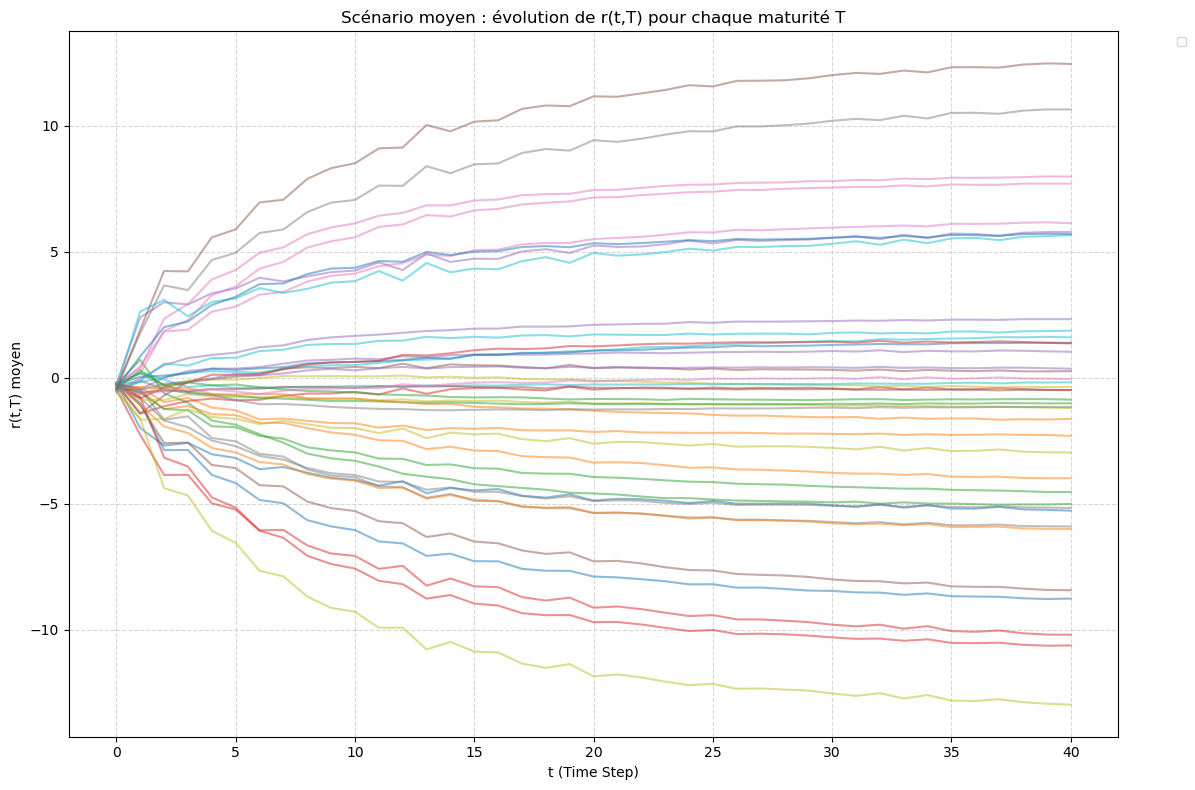

In [ ]:
#allure du scénario moyen de l'IA avec 100 scénarios
import numpy as np
import matplotlib.pyplot as plt

# new_scenarios a shape (100, 41, 40)
# Moyenne sur les 100 scénarios → shape (41, 40)
scenario_moyen = np.mean(new_scenarios, axis=0)

# Tracé des courbes de T fixés (maturités)
plt.figure(figsize=(10, 6))
for T in range(scenario_moyen.shape[1]):  # T de 0 à 39
    plt.plot(range(scenario_moyen.shape[0]), scenario_moyen[:, T], alpha=0.5)

plt.title("Scénario moyen : évolution de r(t,T) pour chaque maturité T")
plt.xlabel("t (Time Step)")
plt.ylabel("r(t,T) moyen")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


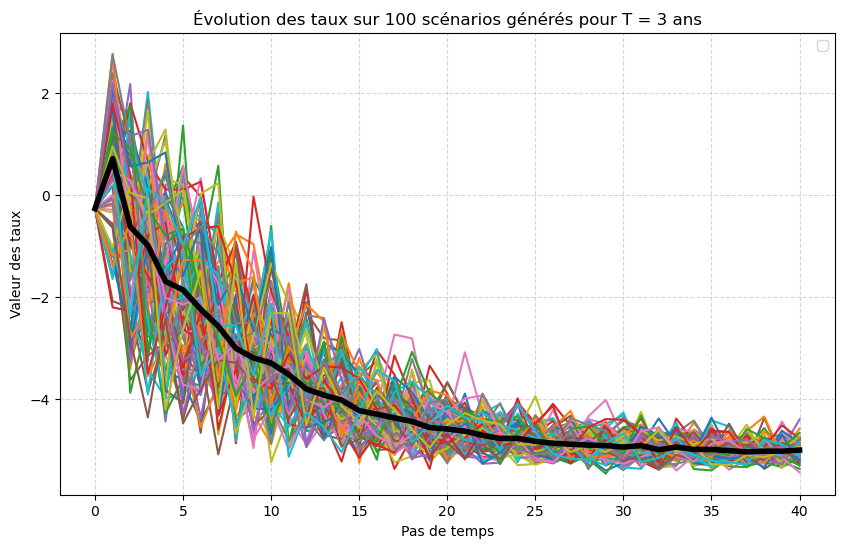

In [110]:
#si on regarde juste EUR_Nom_Spot_3 de l'IA pour 100 scénarios
import matplotlib.pyplot as plt
import numpy as np

# Tracer les 5 premiers scénarios
plt.figure(figsize=(10, 6))

# Liste pour stocker les Y moyens
average_Y = []

for i in range(100):  # Prendre seulement les 5 premiers scénarios
    Y = []
    X = []
    for j in range(41):  # Supposons qu'on ait 41 pas de temps
        Y.append(new_scenarios[i][j][2])  # Récupérer la valeur du taux à l'index 2
        X.append(j)  # Pas de temps
    plt.plot(X, Y)  # Tracer chaque scénario
    average_Y.append(Y)  # Ajouter le scénario à la liste des Y pour calculer la moyenne

# Calculer la moyenne des Y à chaque X (pas de temps)
average_Y = np.mean(average_Y, axis=0)

# Tracer la courbe moyenne
plt.plot(X, average_Y, color='black', linestyle='-', linewidth=4)

plt.title('Évolution des taux sur 100 scénarios générés pour T = 3 ans')
plt.xlabel('Pas de temps')
plt.ylabel('Valeur des taux')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


In [133]:
#chargement des données avec 3000 scénarios
data3000=pd.read_csv("EUR_4Q24_EUR_3000.csv",sep=";", encoding="utf-8")
data3000 = data3000.replace(',', '.', regex=True).astype(float)
data3000.columns = data3000.columns.str.replace(' ', '_')
# Détection des colonnes de taux
rate_columns = [col for col in data3000.columns if 'EUR_Nom_Spot_' in col]
from sklearn.preprocessing import StandardScaler

# Sélectionne uniquement les colonnes de taux
rate_data3000 = data3000[rate_columns]

# Initialise le scaler et transforme les taux
scaler3000 = StandardScaler()
scaled_rates3000 = scaler3000.fit_transform(rate_data3000)

# Mets à jour le DataFrame original avec les taux normalisés
data3000[rate_columns] = scaled_rates3000

print(data3000)

        Scenario  Time_Step  EUR_Nom_Spot_1  EUR_Nom_Spot_2  EUR_Nom_Spot_3  \
0            1.0        0.0       -0.193478       -0.240620       -0.245116   
1            1.0        1.0       -0.766928       -0.761072       -0.753216   
2            1.0        2.0       -1.032563       -1.028366       -1.026131   
3            1.0        3.0       -1.198082       -1.198398       -1.188977   
4            1.0        4.0       -1.135442       -1.118800       -1.105551   
...          ...        ...             ...             ...             ...   
122995    3000.0       36.0        3.881528        3.856499        3.824822   
122996    3000.0       37.0        3.710743        3.671720        3.638406   
122997    3000.0       38.0        3.393731        3.358920        3.366595   
122998    3000.0       39.0        3.408242        3.435191        3.465989   
122999    3000.0       40.0        3.457817        3.486793        3.555872   

        EUR_Nom_Spot_4  EUR_Nom_Spot_5  EUR_Nom_Spo

In [ ]:
# Initialisation et entraînement avec 3000 scénarios
pigan3000a = InterestRatePIGAN(latent_dim=128, 
                         time_steps=41, 
                         rate_columns=rate_columns)


pigan3000a.train(data3000, epochs=300, batch_size=64)

Epoch 0 | Adv Loss: 0.6206 | Phys Loss: 0.2540
Epoch 50 | Adv Loss: 0.0366 | Phys Loss: 0.9645
Epoch 100 | Adv Loss: 0.0244 | Phys Loss: 1.0392
Epoch 150 | Adv Loss: 0.0170 | Phys Loss: 0.8709
Epoch 200 | Adv Loss: 0.0154 | Phys Loss: 0.8534
Epoch 250 | Adv Loss: 0.0143 | Phys Loss: 0.7564


In [ ]:
pigan3000b = InterestRatePIGAN(latent_dim=32, 
                         time_steps=41, 
                         rate_columns=rate_columns)
pigan3000b.train(data3000, epochs=300, batch_size=32)

In [ ]:
# Génération de scénarios3000
new_scenarios3000 = pigan3000a.generate_scenarios(data,n_scenarios=100)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


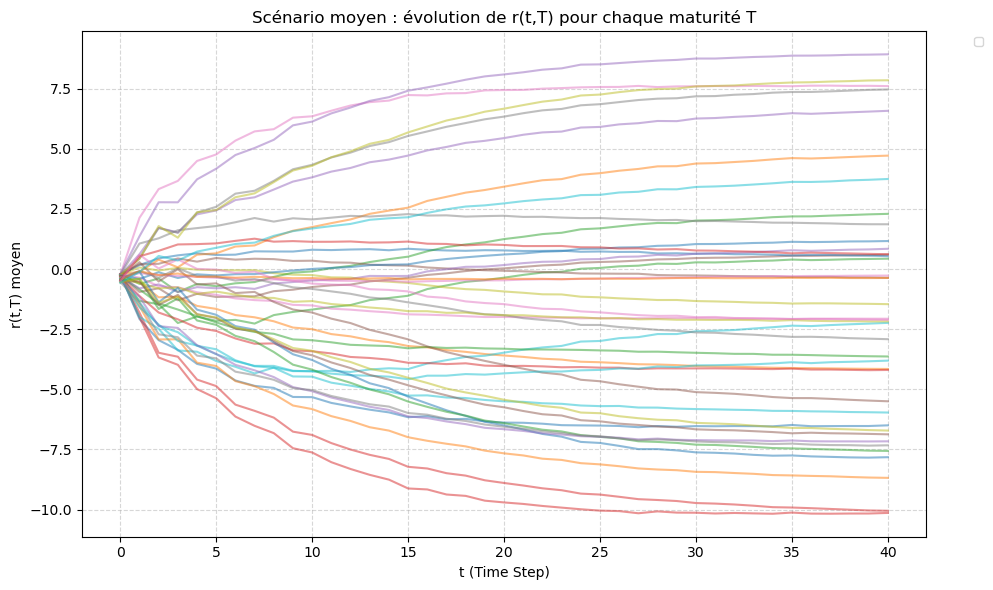

In [118]:
#allure du scénario moyen de l'IA3000 avec 100 scénarios
import numpy as np
import matplotlib.pyplot as plt

# new_scenarios a shape (100, 41, 40)
# Moyenne sur les 100 scénarios → shape (41, 40)
scenario_moyen3000 = np.mean(new_scenarios3000, axis=0)

# Tracé des courbes de T fixés (maturités)
plt.figure(figsize=(10, 6))
for T in range(scenario_moyen3000.shape[1]):  # T de 0 à 39
    plt.plot(range(scenario_moyen3000.shape[0]), scenario_moyen3000[:, T], alpha=0.5)

plt.title("Scénario moyen : évolution de r(t,T) pour chaque maturité T")
plt.xlabel("t (Time Step)")
plt.ylabel("r(t,T) moyen")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


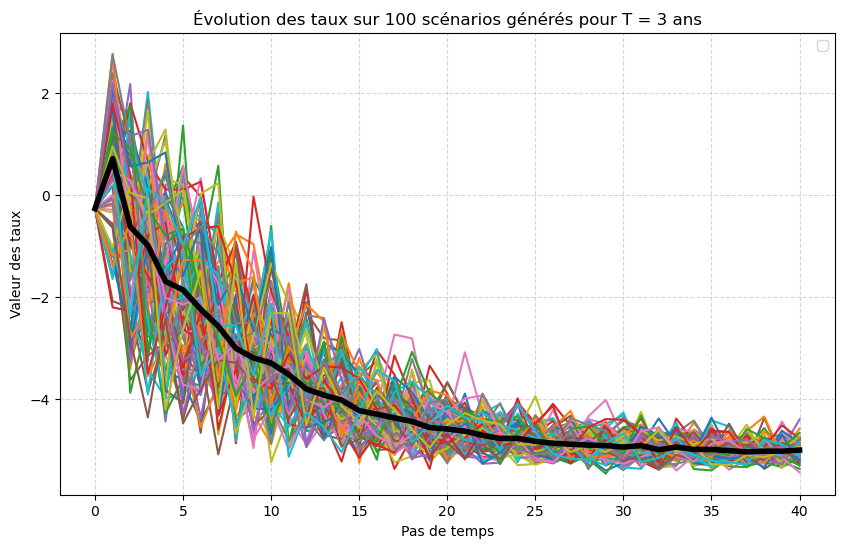

In [ ]:
#si on regarde juste EUR_Nom_Spot_3 de l'IA3000 pour 100 scénarios
import matplotlib.pyplot as plt
import numpy as np

# Tracer les 5 premiers scénarios
plt.figure(figsize=(10, 6))

# Liste pour stocker les Y moyens
average_Y = []

for i in range(100): 
    Y = []
    X = []
    for j in range(41):  # Supposons qu'on ait 41 pas de temps
        Y.append(new_scenarios[i][j][2])  # Récupérer la valeur du taux à l'index 2
        X.append(j)  # Pas de temps
    plt.plot(X, Y)  # Tracer chaque scénario
    average_Y.append(Y)  # Ajouter le scénario à la liste des Y pour calculer la moyenne

# Calculer la moyenne des Y à chaque X (pas de temps)
average_Y = np.mean(average_Y, axis=0)

# Tracer la courbe moyenne
plt.plot(X, average_Y, color='black', linestyle='-', linewidth=4)

plt.title('Évolution des taux sur 100 scénarios générés pour T = 3 ans')
plt.xlabel('Pas de temps')
plt.ylabel('Valeur des taux')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()
